# FFR120 Simulation of Complex Systems - Crowd Disasters
**Group** - Team Butterflies

**Members**:
- Artur ..
- Maria
- Nina
- Ruiqi
- Rundong .,

In [1]:
%matplotlib notebook

import numpy as np
import pandas as pd
import math

import matplotlib.pyplot as plt
import matplotlib.animation as anim
import matplotlib.patches as patches

from sim_state import SimState
from constants import Environment as env
from constants import PersonState as pstate
from constants import SimConstants as sconst
from forces import get_forces

In [2]:
class AnimationSettings:
    display_size = 8, 8   # Size of display in inches
    dpi = 100    # Pixels per inch
    framerate = 15
    exit_color = "#00FF00"
    wall_color = "000000"
    
    def get_marker_size():
        return (
            AnimationSettings.dpi *
            np.mean(AnimationSettings.display_size) *
            sconst.individual_radius /
            np.mean(sconst.max_pos)
        )
    
    
seed = 69420
rng = np.random.default_rng(seed)
gif_writer = anim.PillowWriter(fps=AnimationSettings.framerate)
save_animation = True
save_history = True

## Simulation


In [3]:
def get_environmental_force(individual, state) -> float:
    """Net forces acting on an individual caused by the environment"""
    
    # Compute the displacement between this individual and all others, p_i - p_j.
    displacements = state.positions[individual, :] - state.positions

    # The distance to each individual is the norm of each displacement |p_i - p_j|.
    distances = np.linalg.norm(displacements, axis=1)

    # Find all the collisions that occur, which is defined as the instances
    # where the distances are within 2 radiuses, since this means that each
    # perimeter is just barely touching.
    # Exclude the instances where the distance is 0, since this means that
    # the individual is being compared to itself (or something has gone terribly wrong):
    collisions = (
        (state.person_states == pstate.living) &
        (distances < 2*sconst.individual_radius) &
        (distances > 0)
    )
    if collisions.size == 0:
        net_environmental_force = 0
    else:
        
        net_environmental_force = np.sum(sconst.collision_rebound / displacements[collisions], axis=0)
            
    return net_environmental_force

In [4]:
def get_obstacle_forces(state) -> np.ndarray:
    # The obstacle force between a given individual is defined as F_obs = e^(-d/r_0),
    # where d is the distance between the individual and the obstacle,
    # and r_0 is a parameter that determines how fast the force scaled with distance.
    
    obstacle_forces = np.zeros(shape=sconst.shape_2d)
    
    # TODO: Optimize
    for individual in range(sconst.n_individuals): 
        x = state.positions[individual,0]
        y = state.positions[individual,1]
        
        w_bot_surf_y = env.walls[0][2, 1]
        w_right_surf_x = env.walls[1][0, 0]
        w_top_surf_y = env.walls[2][0, 1]
        w_left_surf_x = env.walls[3][1, 0]
        
        disp = np.zeros((2,))
        
        if x < w_left_surf_x + sconst.distance_wall:
            disp[0] = w_left_surf_x - x
        
        elif x > w_right_surf_x - sconst.distance_wall :
            disp[0] = w_right_surf_x - x
            
        else:
            disp[0] = 0
            
            
        if y < w_bot_surf_y + sconst.distance_wall:
            disp[1] = w_bot_surf_y - y
            
        elif y > w_top_surf_y - sconst.distance_wall:
            disp[1] = w_top_surf_y - y
            
        else:
            disp[1] = 0
            
        dist = np.linalg.norm(disp)
        
        if dist == 0:
            force = 0
        else:
            force = disp / dist * math.exp(-dist/sconst.r_0)
        
        
        # TODO
        obstacle_forces[individual] = force


            
    return obstacle_forces
             
    

In [5]:
def get_environmental_forces(state):
    forces = np.zeros(shape=sconst.shape_2d)
    active = state.person_states == pstate.living
    
    for individual in range(sconst.n_individuals): 
        if not active[individual]:
            continue
                
        env_force = get_environmental_force(individual, state)
        forces[individual] = env_force
        
    for wall, wall_face in zip(env.walls, env.wall_face):
        i_colliding = get_touching_individuals_with_rectangle(state.positions, wall)
        if len(i_colliding[0]) == 0:
            continue

        # The wall will enact a force in the direction of the wallface.
        # The amount by which will be proportional to the projection of the 
        # velocity vector into the face (orthagonal) vector of the wall.
        #
        # Projecting the velocity vector into the face vector is done with the formula
        #   w = (v*u)/|u|^2 * u,
        # where v is the velocity vector and u is the face vector.
        # In this case, the face vector will always be normalised, so |u|^2 = 1
        #
        # Since the velocities are stored in a matrix, this can effeciently be done with
        #   W = V*u*u,
        # as this will essentially be reduced to
        #   w1 = v1*u*u, w2 = v2*u*u, ...
        # Observe that this is component-wise product, not dot product
        
        overlap = state.velocities[i_colliding]*wall_face
        forces[i_colliding] -= overlap * wall_face * sconst.wall_rebound
         
    return forces         

In [6]:
def get_desire_forces(state):
    forces = np.zeros(shape=sconst.shape_2d)
    active = state.person_states == pstate.living
    
    exit = env.exits[0]
    exit_center = exit[0]+(exit[2]-exit[0])/2
    
    for individual in range(sconst.n_individuals): 
        if not active[individual]:
            continue
            
        displacement = exit_center - state.positions[individual]
        desired_direction = displacement / np.linalg.norm(displacement)

        velocity = state.velocities[individual]    
        optimal_velocity = desired_direction*sconst.v_max

        desire_force = sconst.individual_force * (optimal_velocity - velocity)
            
        forces[individual] = desire_force
        
    return forces

In [7]:
def get_social_forces(state):
    forces = np.zeros(shape=sconst.shape_2d)
    active = state.person_states == pstate.living
    
    desire_forces = get_desire_forces(state)
    obstacle_forces = get_obstacle_forces(state)
    forces += desire_forces + obstacle_forces
    
    return forces


In [8]:
def get_overlap_individuals_with_rectangle(positions, rectangle):
    bbox_botleft = positions - sconst.individual_radius
    bbox_topright = positions + sconst.individual_radius
    
    rect_botleft = rectangle[0, :]
    rect_topright = rectangle[2, :]
    
    i_rect_overlap = np.where(
        (bbox_botleft[:, 0] > rect_botleft[0]) &
        (bbox_topright[:, 0] < rect_topright[0]) &
        (bbox_botleft[:, 1] > rect_botleft[1]) &
        (bbox_topright[:, 1] < rect_topright[1])
    )
    
    return i_rect_overlap


def get_touching_individuals_with_rectangle(positions, rectangle):    
    bbox_botleft = positions - sconst.individual_radius
    bbox_topright = positions + sconst.individual_radius
        
    rect_botleft = rectangle[0, :]
    rect_topright = rectangle[2, :]
    
    b_left = bbox_botleft[:, 0]
    b_right = bbox_topright[:, 0]
    b_bot = bbox_botleft[:, 1]
    b_top = bbox_topright[:, 1]
    
    r_left = rect_botleft[0]
    r_right = rect_topright[0]
    r_bot = rect_botleft[1]
    r_top = rect_topright[1]
    
    i_rect_overlap = np.where(
        (
            ((b_right > r_left) & (b_right < r_right)) |
            ((b_left > r_left) & (b_left < r_right))
        ) &
        (
            ((b_top > r_bot) & (b_top < r_top)) |
            ((b_bot > r_bot) & (b_bot < r_top))
        )
    )
    
    return i_rect_overlap
    

In [9]:
def get_initial_positions():
    radius = sconst.individual_radius
    diameter = 2 * radius
    width = env.right_inner - env.left_inner
    height = env.top_inner - env.bot_inner
            
    n_x = int(width // diameter)
    n_y = int(height // diameter)
    choices = []
    
    for i_y in range(n_y):
        for i_x in range(n_x):
            x = env.left_inner + radius + i_x * diameter
            y = env.bot_inner + radius + i_y * diameter
            choices.append((x, y))
            
    rng.shuffle(choices)
    
    positions = np.array(choices[:sconst.n_individuals], dtype=float)
    return positions

In [10]:
def run_simulation() -> list[SimState]:   
    max_pos = np.array(sconst.max_pos)
    
    state = SimState(
        #positions = (
        #    sconst.start_margin * max_pos +
        #    np.random.rand(*sconst.shape_2d) * max_pos * (1-2*sconst.start_margin)
        #),
        positions=get_initial_positions(),
        velocities=np.zeros(shape=sconst.shape_2d),
        forces=np.zeros(shape=sconst.shape_2d),
        pressures=np.zeros(shape=sconst.shape_1d),
        person_states=np.zeros(shape=sconst.shape_1d)
    )
    
    history = [state.copy()]
    
    for time_step in range(sconst.n_time_steps):
        if (time_step+1) % 100 == 0:
            print(f"Time step: {time_step}/{sconst.n_time_steps-1}")
            
        active = state.person_states == pstate.living
        
        state.positions[active] = state.positions[active] + state.velocities[active] * sconst.time_inc
        #state.forces = np.zeros(shape=shape_2d)
        #state.pressures = np.zeros(shape=shape_1d)
        
        #env_forces = get_environmental_forces(state) 
        #social_forces = get_social_forces(state)
        env_forces, social_forces = get_forces(state)

        state.forces = env_forces + social_forces
        state.pressures = np.linalg.norm(env_forces, axis=1)
        
        #for individual in range(SimConstants.n_individuals): 
         #   if not active[individual]:
          #      continue
                
           # env_force = get_environmental_force(individual, state)
            #state.forces[individual] += env_force
            #state.pressures[individual] += np.linalg.norm(env_force)
            #state.forces[individual] += get_social_force(individual, state)

        #for wall, wall_face in zip(env.walls, env.wall_face):
        #    i_colliding = get_touching_individuals_with_rectangle(state.positions, wall)
        #    overlap = (
        #        wall_face[0]*state.velocities[i_colliding, 0] +
        #        wall_face[1]*state.velocities[i_colliding, 1]
        #    )
        #    state.forces[i_colliding] -= wall_face*overlap.T * sconst.collision_rebound
            
            
        state.velocities[active] = (
            state.velocities[active] +
            state.forces[active] * sconst.force_scalar
        )
        
        i_exiting = get_overlap_individuals_with_rectangle(state.positions, env.exits[0])
        state.person_states[i_exiting] = pstate.exited
        
        i_dead = state.pressures > sconst.lethal_pressure
        state.person_states[i_dead] = pstate.dead
                
        history.append(state.copy())

    return history

In [11]:
v = np.arange(10).reshape(5, 2)
a = v / np.linalg.norm(v, axis=1, keepdims=True)
v[:, 1]


print(v)
print(np.vstack((-v[:, 1], v[:, 0])).T)

[[0 1]
 [2 3]
 [4 5]
 [6 7]
 [8 9]]
[[-1  0]
 [-3  2]
 [-5  4]
 [-7  6]
 [-9  8]]


In [12]:
print("START HISTORY")
history = run_simulation()

START HISTORY
Time step: 99/999
Time step: 199/999
Time step: 299/999
Time step: 399/999
Time step: 499/999
Time step: 599/999
Time step: 699/999
Time step: 799/999
Time step: 899/999
Time step: 999/999


## Animation

In [13]:
def get_time_step(i_frame: int, frame_rate: int, time_inc: float) -> int:
    """Get the time step corresponding to actual time passed of simulation.

    Example:
        50 fps -> 0.02s per frame
        0.01 time_inc -> 2 time steps per frame
        3 frames -> 6 time_steps

    Args:
        i_frame: The frame currently being rendered:
        frame_rate: Number of frames rendered per second.
        time_inc: The time passed between time steps.
    """
    return int((i_frame / frame_rate) / time_inc)


def get_rectangle_pos_and_size_for_patch(rect) -> tuple[np.ndarray, float, float]:
    """Extract position, width, and height from the rectangle.
    
    Each rectangle is defined by the points (topleft, topright, botright, botleft).
    A patch is defined by the (botleft, width, height).
    """
    
    pos = rect[0, :]
    w = rect[2, 0]-rect[0, 0]
    h = rect[2, 1]-rect[0, 1]
    return pos, w, h 


def render_state(i_frame, fig, history, screen_live, screen_dead, screen_exit):
    i_time = get_time_step(i_frame, AnimationSettings.framerate, sconst.time_inc)
    
    if i_time > len(history):
        return screen_live, screen_dead, screen_exit
    #i_time = i_frame
    
    state = history[i_time]
    
    pos_dead = state.positions[state.person_states == pstate.dead]
    screen_dead.set_data(pos_dead[:, 0], pos_dead[:, 1])
    
    pos_exit = state.positions[state.person_states == pstate.exited]
    screen_exit.set_data(pos_exit[:, 0], pos_exit[:, 1])
    
    pos_live = state.positions[state.person_states == pstate.living]
    screen_live.set_data(pos_live[:, 0], pos_live[:, 1])
        
    return screen_live, screen_dead, screen_exit


def render_simulation(history: list[SimState]) -> None:
    fig = plt.figure(
        figsize=AnimationSettings.display_size,
        dpi=AnimationSettings.dpi
    )
    ax = fig.gca()

    screen_live, = ax.plot([], [], 'bo', ms=AnimationSettings.get_marker_size())
    screen_dead, = ax.plot([], [], 'ro', ms=AnimationSettings.get_marker_size())
    screen_exit, = ax.plot([], [], 'go', ms=AnimationSettings.get_marker_size())
    
    for exit in env.exits:
        exit = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(exit),
            color=AnimationSettings.exit_color
        )
        ax.add_patch(exit)
        
    for wall in env.walls:
        wall = patches.Rectangle(
            *get_rectangle_pos_and_size_for_patch(wall),
            color=AnimationSettings.wall_color
        )
        ax.add_patch(wall)
    
    ax.set_xlim(env.left_outer, env.right_outer)
    ax.set_ylim(env.bot_outer, env.top_outer)
        
    animation = anim.FuncAnimation(
        fig=fig, func=render_state, frames=sconst.simulation_time*AnimationSettings.framerate,
        fargs=(fig, history, screen_live, screen_dead, screen_exit),
        blit=True, interval=int(1000/AnimationSettings.framerate)
    )
    return animation
    

<IPython.core.display.Javascript object>


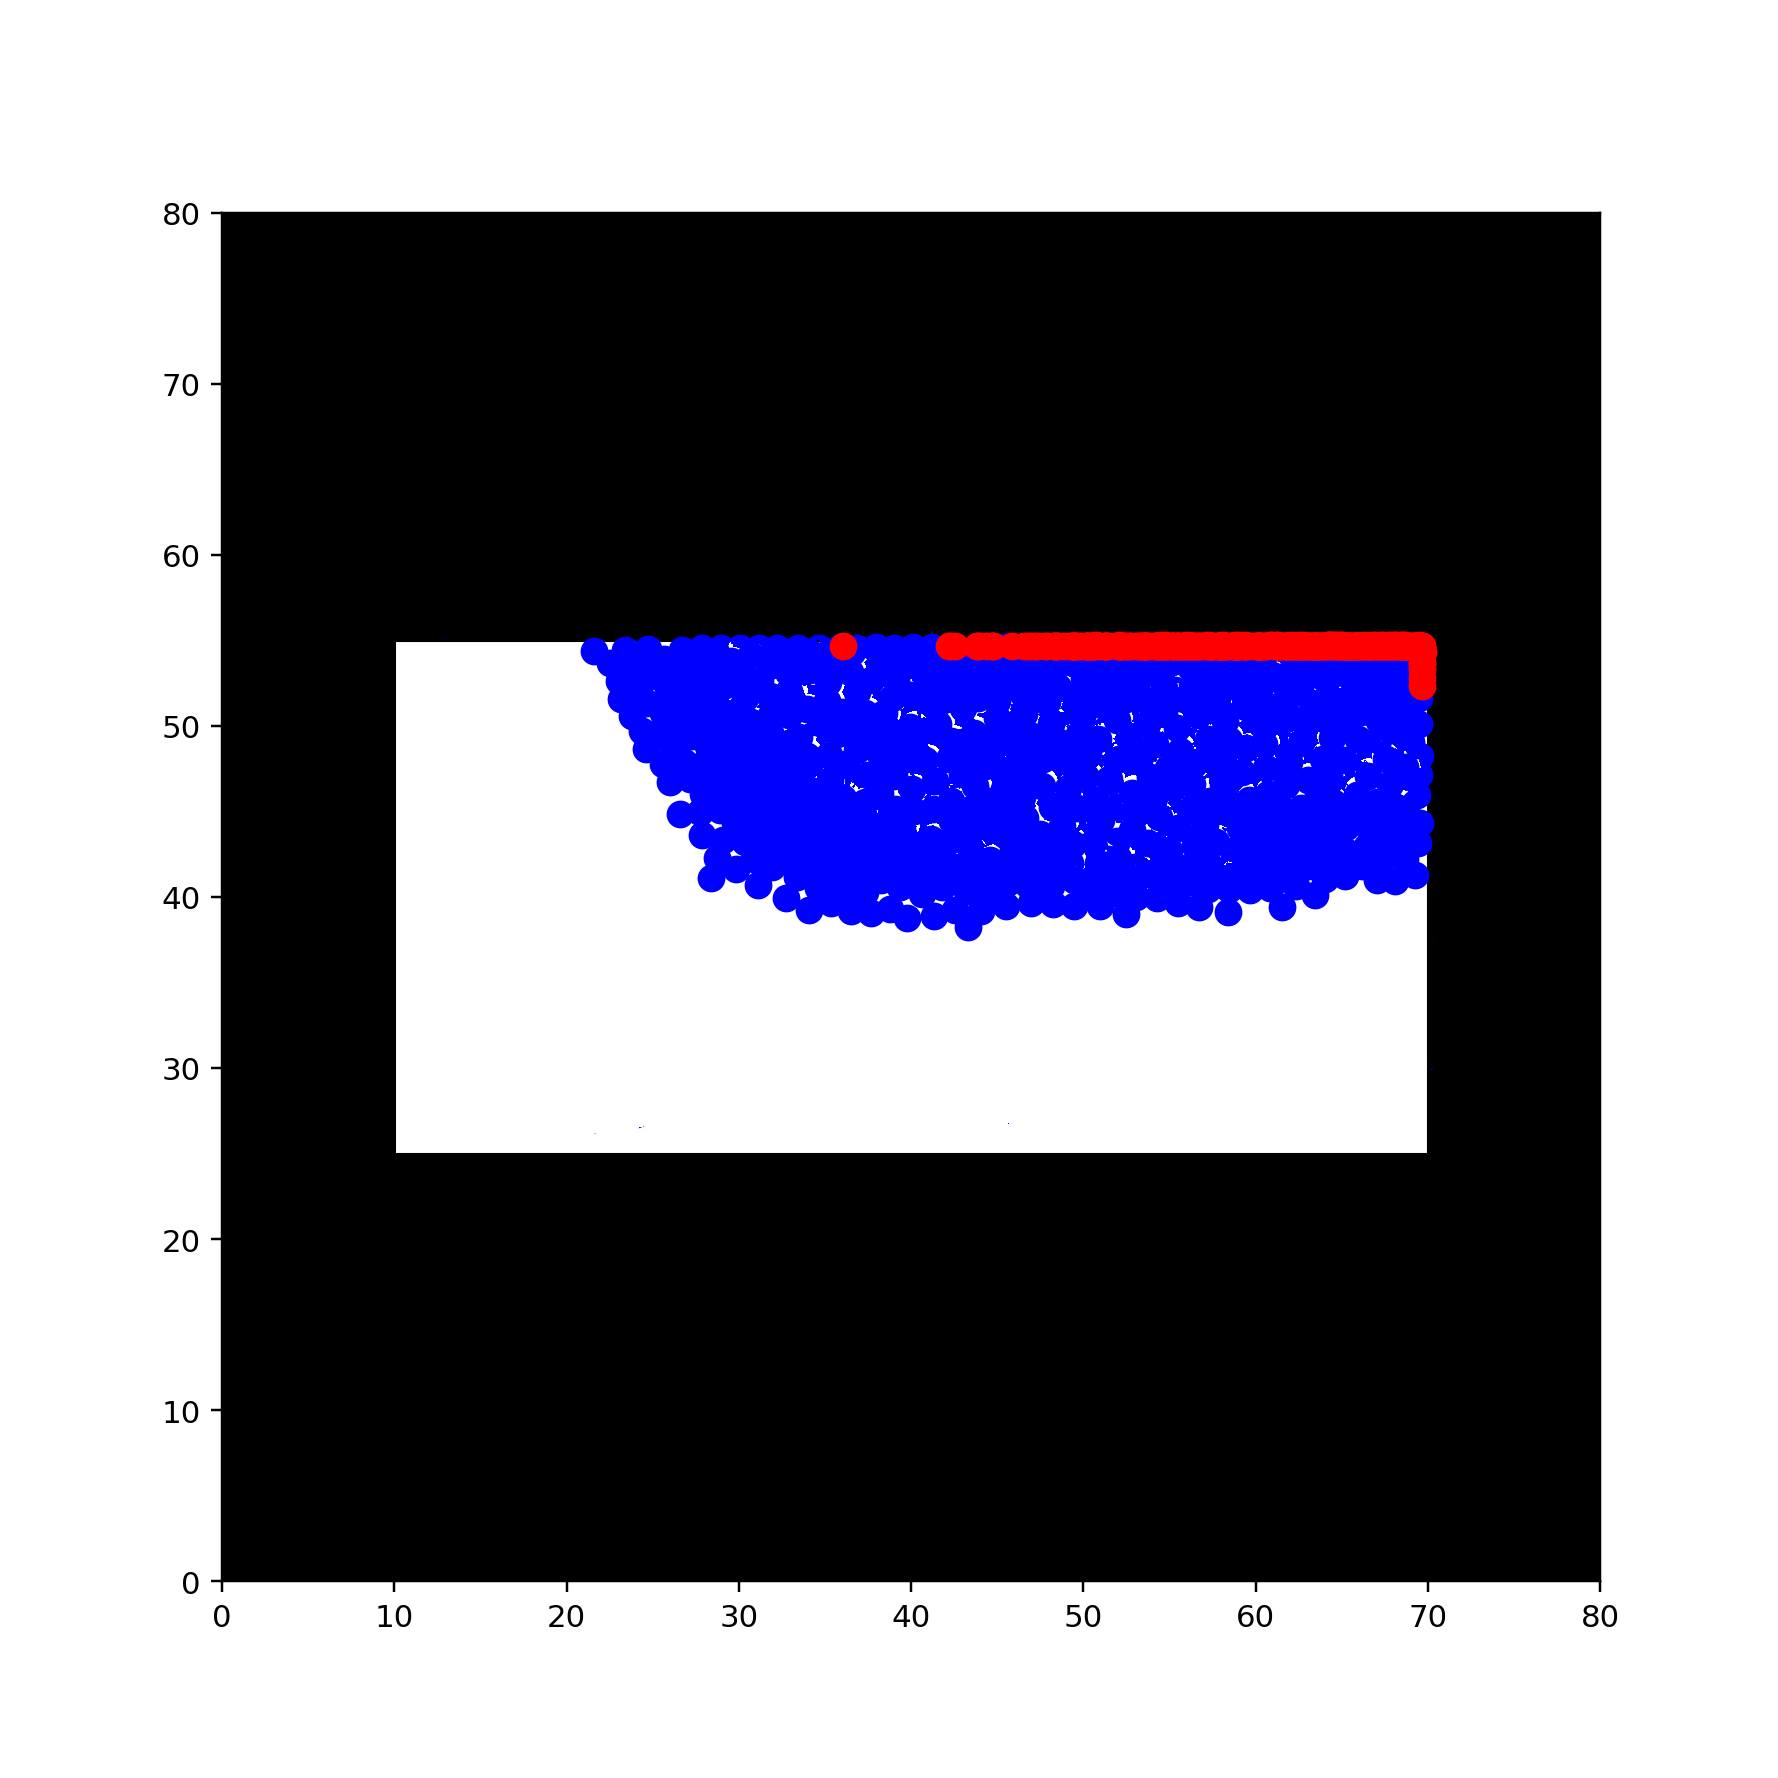

In [14]:
animation = render_simulation(history)

## Save data

In [15]:
if save_animation:
    animation.save("./gifs/animation.gif", writer=gif_writer)

In [16]:
def history_to_dataframe(history):
    frames = []

    for i in range(sconst.n_time_steps):
        frame = history[i]
        stacked_frame = np.hstack([
            frame.positions,
            frame.velocities,
            frame.forces,
            frame.pressures.reshape(-1, 1),
            frame.person_states.reshape(-1, 1)
        ])
        frames.append(stacked_frame)

    stacked_history = np.vstack(frames)
    stacked_history.shape
    return pd.DataFrame(stacked_history, columns=[
        "position_x", "position_y", "velocity_x", "velocity_y",
        "force_x", "force_y", "pressure", "person_state"
    ])   

In [17]:
if save_history:
    df = history_to_dataframe(history)
    df.to_csv('./data/data.csv', index=False)